In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import imageio

In [2]:
# 2D Discrete Cosine Transform 
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [3]:
#%% VARIABLES FOR YOU TO CHANGE
path_to_your_image = "1.jpg"
zoom_out=0.9999999 #Fraction of the image you want to keep.

#%% Get image and create y
# read original image and downsize for speed
Xorig =imageio.imread(path_to_your_image, pilmode='RGB') # read in RGB
print(Xorig.shape)

(100, 99, 3)


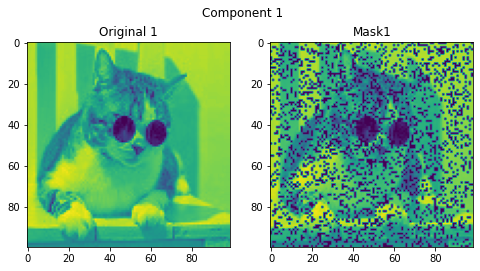

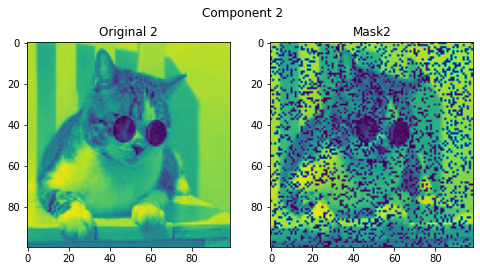

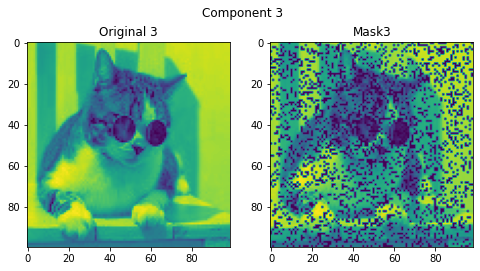

In [4]:
#Downsize image 
X3 = spimg.zoom(Xorig, zoom_out)
ny,nx = X3.shape[0:2]

corruption=0.50 #Fraction of the pixels that you want to discard
retain=1-corruption
k = round(nx * ny * retain) 
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices

# treating red, green, blue components of image seperately to find A_inv,y and c for each component
for i in range(3):
    # extract small sample of signal
    X = X3[:,:,i]
    b = X.T.flat[ri]
    b = np.expand_dims(b, axis=1)

    #%% CREATE A inverse and C
    # *******************************************************************************************
    """This part consumes a lot of memory. Your PC might crash if the images you load are larger than 100 x 100 pixels """
    # create dct matrix operator using kron (memory errors for large ny*nx)
    Aa = np.kron(
        np.float16(spfft.idct(np.identity(nx), norm='ortho', axis=0)),
        np.float16(spfft.idct(np.identity(ny), norm='ortho', axis=0))
        )
    A = Aa[ri,:] # same as B times A

    # *******************************************************************************************
    # create images of mask (for visualization)
    mask = np.zeros(X.shape)
    mask.T.flat[ri] = True
    mask[mask==0]=False
    masked=X*mask
    Xm = 255 * np.ones(X.shape)
    Xm.T.flat[ri] = X.T.flat[ri]

    #%%
    plt.figure(figsize=(8,4));
    plt.suptitle("Component "+str(i+1))
        
    plt.subplot(121);
    plt.imshow(X)
    plt.title("Original "+str(i+1))
    
    plt.subplot(122);
    plt.imshow(masked)
    plt.title("Mask"+str(i+1))

    #%% SAVE MATRICES TO DRIVE
    import os
    dir_name="Data For Assignment/"+str(int(corruption*100))
    try:
        os.mkdir(dir_name)
    except Exception as e:
        pass

    np.save(dir_name+'/C'+str(i+1)+'_'+str(int(corruption*100)),A)
    np.save(dir_name+'/A_inv'+str(i+1)+'_'+str(int(corruption*100)),Aa)
    np.save(dir_name+'/y'+str(i+1)+'_'+str(int(corruption*100)),b)
    plt.imsave(dir_name+'/incomplete'+str(i+1)+'_'+str(int(corruption*100))+'.png',Xm);
    plt.imsave(dir_name+'/original_with_crop'+str(i+1)+'_'+str(int(corruption*100))+'.png',X)